In [ ]:
#1st Attempt
"""    
    pf_out2 = []
    for pf_rep in range(NREPS_EVAL): 
        key, subkey = random.split(key)
        pf_out2.append(pypomp.pfilter.pfilter(
            #pomp_object = sp500_model,
            pomp_object = fit_out_gd[-1],
            J = NP_EVAL,
            thresh = 0,
            key = subkey
        ))
    pf_out.append([np.mean(pf_out2), np.std(pf_out2)])
"""

AttributeError: 'tuple' object has no attribute 'pfilter'

pypomp.pfilter.pfilter() is trying to call .pfilter() on an object that is a tuple, not a Pomp model

pypomp.fit.fit() function doesn't return a Pomp model

Need to extract Pomp model from fit_out_gd???

In [ ]:
#2nd Attempt
#pomp_object = fit_out_gd[-1][0] 

AttributeEnsiorror: 'jaxlib.xla_exten.ArrayImpl' object has no attribute 'pfilter'
pypomp.pfilter.pfilter() is called on object of type jaxlib.xla_extension.ArrayImpl not Pomp model

In [ ]:
"""
fit_result = pypomp.fit.fit(
    pomp_object = sp500_model,
    J = NP_FITR,
    method = "Newton",
    itns = 20,
    mode = "GD"
)
print("fit_result type:", type(fit_result))
print("fit_result content:", fit_result)

fit_out_gd.append(fit_result)
"""

fit_result type: <class 'tuple'> 
(
Array(
    [5.761906e+29,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan], dtype=float32
    ), 

Array(
    [
        
    [-10.308595 , -15.824013 ,  -9.329866 ,  -4.910471 ,   1.2235351, -13.147099 ],
    [nan, nan, nan, nan, nan, nan]
    
    ], dtype=float32
    )
)


pypomp.fit.fit() didn't converge???
NaN-mopfailed???

In [ ]:
#Last Attempt
#pomp_object = sp500_model

pf type: <class 'list'>
[
    [np.float32(6.652185e+29), np.float32(inf)], [np.float32(5.7257137e+29), np.float32(inf)], [np.float32(1.1205358e+29), np.float32(inf)]
]

pf2 type: <class 'list'>
[
    Array(3.3233526e+29, dtype=float32), Array(2.9167196e+28, dtype=float32), Array(7.106361e+27, dtype=float32), Array(1.7873747e+29, dtype=float32), 

    Array(1.2921582e+28, dtype=float32)
]
0:10:41.325898
[
    [np.float32(6.652185e+29), np.float32(inf)], [np.float32(5.7257137e+29), np.float32(inf)], [np.float32(1.1205358e+29), np.float32(inf)]
]


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pypomp
#import seaborn as sns
from plotnine import ggplot, geom_line, aes, facet_wrap, coord_cartesian, geom_point

In [2]:
def funky_transform(lst):
    """Transform rho to perturbation scale"""
    out = [np.log((1 + x)/(1 - x)) for x in lst]
    return out

### Notes about pkl structure:

- Dictionary with two entries
    - fit_out: A list containing output of the fitting step. Each entry is a replicate from the fitting step.
        - Various entries: A tuple of length 2 containing information for a replicate.
            - Entry 0: A JAX array containing the iterated filtering estimate of the log likelihood for each iteration (plus an extra? check when the extra is added)
            - Entry 1: A JAX array containing parameters from particles. First dimension varies iteration, second varies the particle, and the third varies the parameter.
    - pf_out: A list containing the output of the particle filtering step. 
        - Various entries: A list for a different replicate from the particle filtering step.
            - Entry 0: A numpy.float32 representing the estimated log likelihood.
            - Entry 1: A numpy.float32 representing the estimated standard deviation of the LL estimate.


In [6]:
PKL_PATH = "1d_global_mop_out.pkl"
print(os.getcwd())
pkl_in = pickle.load(open(PKL_PATH, "rb"))

c:\Users\ravis\OneDrive\Documents\danny_honors_thesis\src


In [ ]:
print(type(pkl_in["pf_out"]))
print(type(pkl_in["pf_out"][0]))
print(pkl_in["pf_out"][0])



<class 'list'>
<class 'jaxlib.xla_extension.ArrayImpl'>
8.573195e+29


pf_out list should store LL estimates as [mean, std], but it stores raw JAX arrays.

pf_out.append(pypomp.pfilter.pfilter(
    pomp_object = sp500_model,
    J = NP_EVAL,
    thresh = 0
))
returns a JAX array, but it should be converted to a Python float before appending.

### Final LL estimates:

In [4]:
pd.DataFrame({
    "LL": [x[0] for x in pkl_in["pf_out"]],
    "sd": [x[1] for x in pkl_in["pf_out"]]
}).sort_values(by = "LL")

IndexError: Too many indices: 0-dimensional array indexed with 1 regular index.

### Plot traces

,rep,iter,param_index,param_value
0,0,0,0,-10.308595
1,0,0,1,-15.824013
2,0,0,2,-9.329866
3,0,0,3,-4.910471
4,0,0,4,1.223535
...,...,...,...,...
436,2,16,-1,NaN
437,2,17,-1,NaN
438,2,18,-1,NaN
439,2,19,-1,NaN


c:\Users\ravis\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:99: PlotnineWarning: geom_path: Removed 20 rows containing missing values.


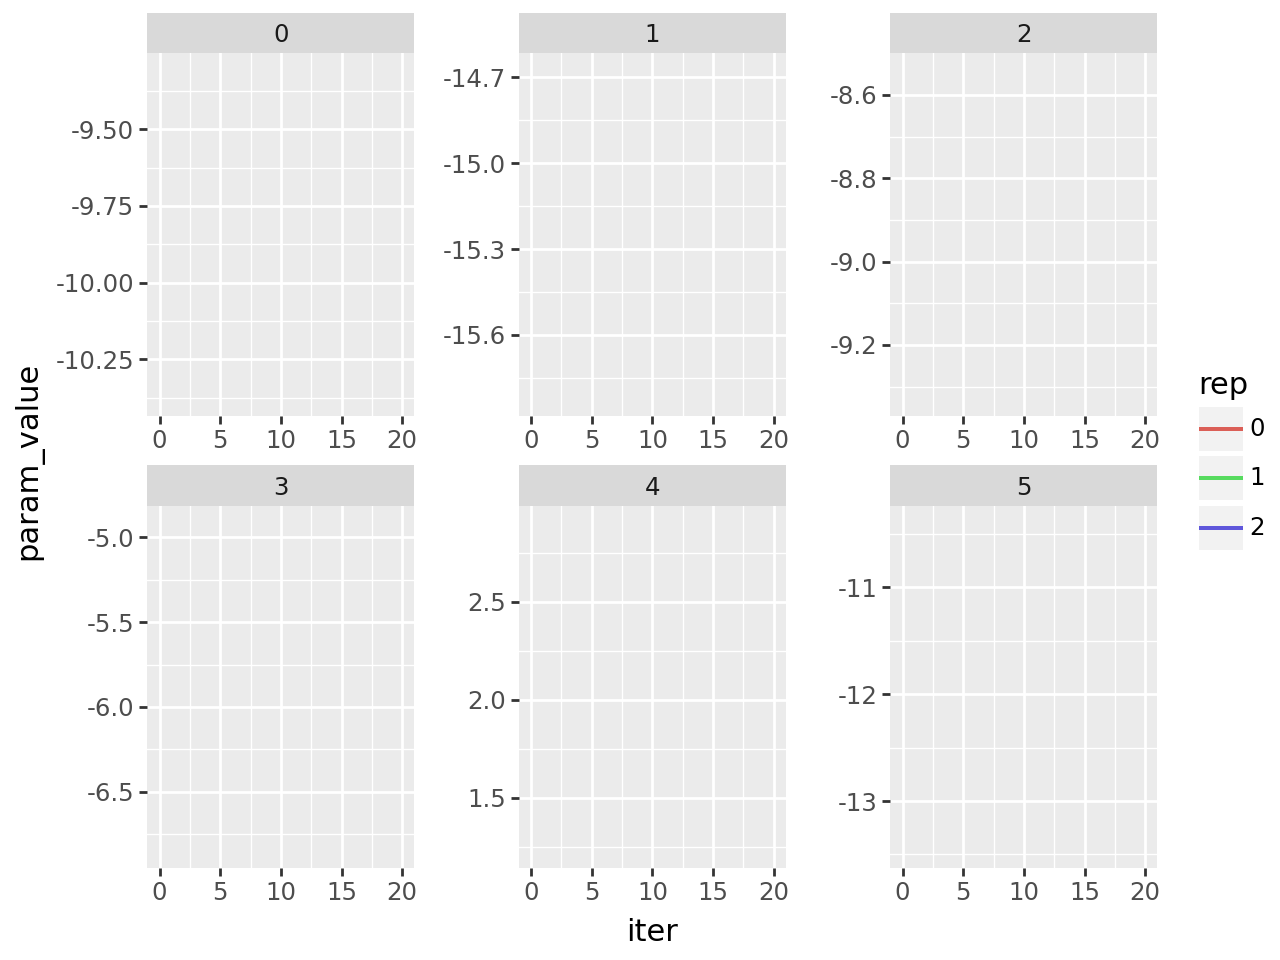

In [6]:
(
    ggplot(
        traces.loc[traces["param_index"] != -1], 
        aes(x = "iter", y = "param_value", group = "rep", color = "rep")
    ) 
    + geom_line()
    + facet_wrap("param_index", scales = "free")
    #+ coord_cartesian(ylim = (0, 5))
)

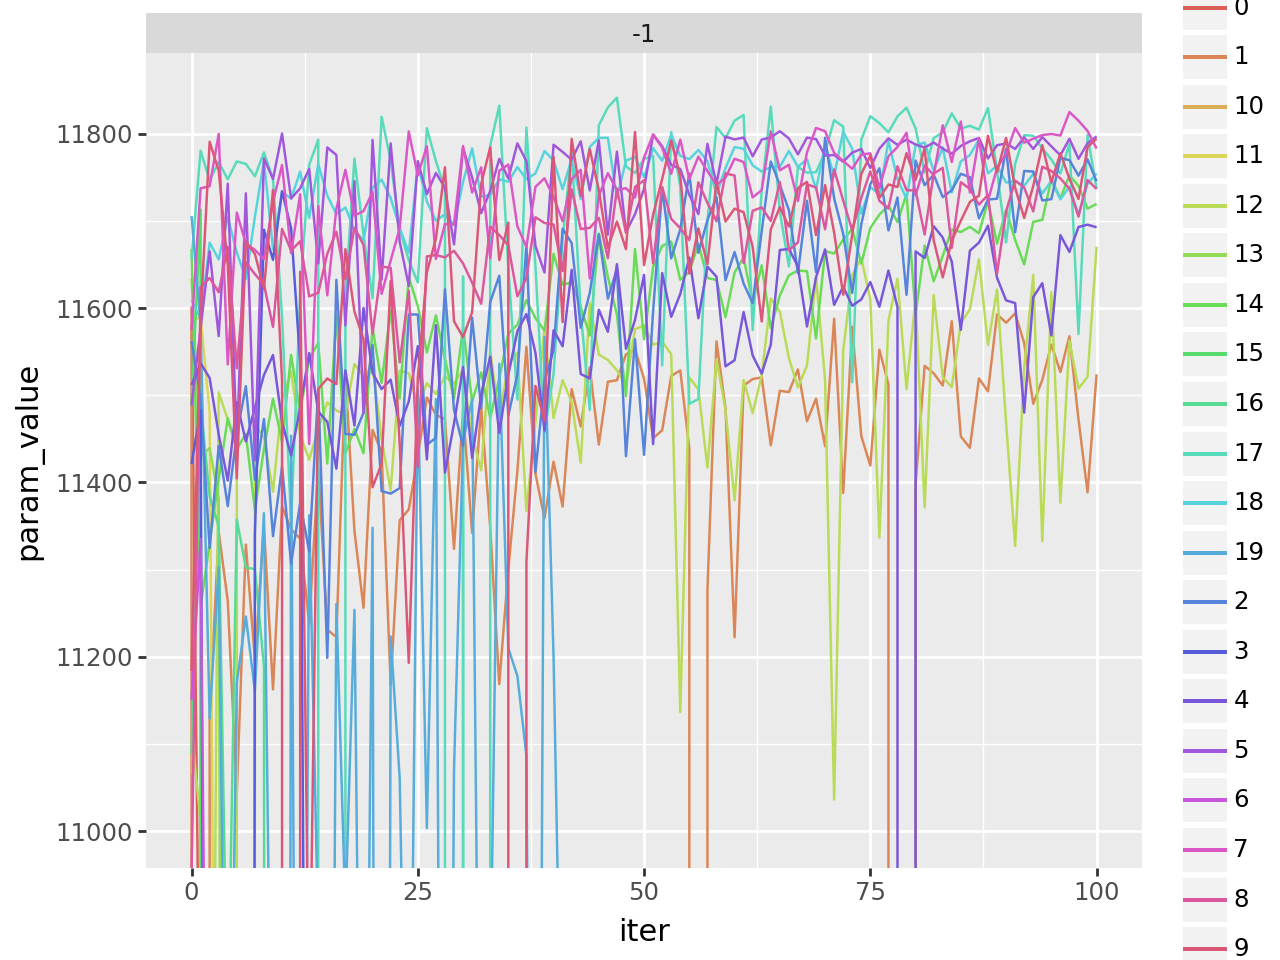

In [ ]:
# LL traces for mop
(
    ggplot(
        traces.loc[traces["param_index"] == -1], 
        aes(x = "iter", y = "param_value", group = "rep", color = "rep")
    ) 
    + geom_line()
    + facet_wrap("rep", scales = "free")
    # + facet_wrap("param_index", scales = "free")
    + coord_cartesian(ylim = (11000, 11850))
)

In [ ]:
# Weizhe values
print("mu: " + str(np.log(3.68e-4)))
print("kappa: " + str(np.log(3.14e-2)))
print("theta: " + str(np.log(1.12e-4)))
print("xi: " + str(np.log(2.27e-3)))
print("rho: " + str(funky_transform([-7.38e-1])))
print("v0: " + str(np.log(7.66e-3**2)))
# Exact is 11847.12 from profiling in Weizhe's thesis

# Evaluating the Weizhe model with the Weizhe parameters under 
# output/1d_global/weizhe_eval yielded LL 11849.65, sd 1.1217372.

mu: -7.907427619795343
kappa: -3.4609473860679296
theta: -9.09701168666918
xi: -6.087975447488826
rho: [np.float64(-1.8921458020642405)]
v0: -9.743486590459273
